<a href="https://colab.research.google.com/github/TanushGoel/PharmaceuticAI/blob/master/PharmaceuticAI_PreTrained_Use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SMILES Notes:**

SMILES = Simplified Molecular Input Line Entry Specification

*   Atoms are shown by atomic symbols
*   Hydrogen atoms are assumed to fill spare valencies
*   Adjacent atoms are connected by single bonds
  *   double bonds are shown by "="
  *   triple bonds are shown by "#"
*   Branching is indicated by parenthesis
*   Ring closures are shown by pairs of matching digits


[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#/media/File:SMILES.png)









## Imports

In [ ]:
# install conda on google colab
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
!conda install -q -c rdkit rdkit -y # for molecule analysis and visualization

In [ ]:
!pip3 install -q chembl_webresource_client # https://www.ebi.ac.uk/chembl/

     |████████████████████████████████| 61kB 3.0MB/s 


In [ ]:
# imports
import pandas as pd
import os
from os import path
import zipfile
import glob
import json
import numpy as np
import random
import tensorflow as tf
import keras
from keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps, IPythonConsole
from chembl_webresource_client.new_client import new_client
from google.colab import files

# suppress rdkit error/warning messages
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.warning')

Using TensorFlow backend.


In [ ]:
tf.__version__

'1.15.0'

In [ ]:
tf.keras.__version__

'2.2.4-tf'

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!nvidia-smi

Sun Jul 19 06:47:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Parse Data

In [ ]:
# double letters for one element turned into single letters that are not in the dataset
double_to_single = {'Si':'q', 'Se':'w', 'Cn':'t', 'Sc':'y', 'Cl':'u', 'Sn':'z', 'Br':'x'} 
single_to_double = {'q':'Si', 'w':'Se', 't':'Cn', 'y':'Sc', 'u':'Cl', 'z':'Sn', 'x':'Br'}
elements_with_double_letters = list(double_to_single)

In [ ]:
element_set = ['C', '(', '=', 'O', ')', 'N', 'c', '1', '$', '2', '3', '4', '#', 'n', 'F', 'u', '-', '[', 'H', ']', 's', 'o', 'S', 't', '5', '6', '+', 'P', 'I', 'x', 'y', 'q', 'B', 'w', '7', '8', 'e', '9', 'b', 'p', '%', '0', 'z']
n_vocab = len(element_set)
element_to_int = dict(zip(element_set, range(0, n_vocab)))
int_to_element = {v: k for k, v in element_to_int.items()}
sequence_length = 100 

In [ ]:
filey = open('pharmaceuticAI_all_compounds.smiles')
structures = [line[:-1] for line in filey]
print("Num Total Samples:", len(structures))
filey.close()

num_sampled = 50000
random.shuffle(structures)
data = structures[:num_sampled]
del structures
print("Num Sampled:", num_sampled)

Num Total Samples: 1591378
Num Sampled: 50000


In [ ]:
def gen_structs(data):

    structs = []
    for structure in data:
        i = 0
        while i < len(structure):
            try:
                if structure[i] + structure[i+1] in elements_with_double_letters:
                    structs.append(double_to_single[structure[i] + structure[i+1]])
                    i+=2
                else:
                    structs.append(structure[i])
                    i+=1
            except:
                    structs.append(structure[i])
                    i+=1
        structs.append("$") # end token

    return structs

def gen_data(structs):

    network_inp = []

    # create input sequences
    for i in range(0, len(structs) - sequence_length):
        sequence_in = structs[i:i + sequence_length]
        network_inp.append([element_to_int[char] for char in sequence_in])
        
    n_patterns = len(network_inp)

    # reshape the input into a format compatible with CuDNNLSTM layers
    network_inp = np.reshape(network_inp, (n_patterns, sequence_length))

    return network_inp

In [ ]:
network_input = gen_data(gen_structs(data))

In [ ]:
max_smiles = 100
max_fasta = 5000
batch_siz = 50000

list_smiles_elements = ['6', '3', '=', 'H', 'C', 'O', 'c', '#', 'a', '[', 't', 'r', 'K', 'n', 'B', 'F', '4', '+', ']', '-', '1', 'P', '0', 'L', '%', 'g', '9', 'Z', '(', 'N', '8', 'I', '7', '5', 'l', ')', 'A', 'e', 'o', 'V', 's', 'S', '2', 'M', 'T', 'u', 'i']
smiles_to_int = dict(zip(list_smiles_elements, range(1, len(list_smiles_elements)+1)))
elements = len(list_smiles_elements) + 1 # added one for empty characters filled in with 0's

amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
amino_to_int = dict(zip(amino_acids, range(1, len(amino_acids)+1)))
aminos = len(amino_acids) + 1 # added one for empty characters filled in with 0's

## Load Models

In [ ]:
smiles_input = layers.Input(shape=(sequence_length,), dtype='int32', name='smiles_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_smiles = layers.Embedding(output_dim=128, input_dim=n_vocab, input_length=sequence_length)(smiles_input) 

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
conv1_smiles = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(embed_smiles)
activation1_smiles = layers.PReLU()(conv1_smiles)
dropout1 = layers.Dropout(0.1)(activation1_smiles)
conv2_smiles = tf.compat.v1.keras.layers.CuDNNLSTM(512, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(dropout1)
activation2_smiles = layers.PReLU()(conv2_smiles)
dropout2 = layers.Dropout(0.1)(activation2_smiles)
conv3_smiles = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(dropout2)
activation3_smiles = layers.PReLU()(conv3_smiles)
dropout3 = layers.Dropout(0.1)(activation3_smiles)

# turn into vector
flatten = layers.Flatten()(dropout3)

# dense layers 
dense1 = layers.Dense(512, activation='relu')(flatten)
dropout1_dense = layers.Dropout(0.1)(dense1)
dense2 = layers.Dense(256, activation='relu')(dropout1_dense)

# output
output = layers.Dense(n_vocab, activation="softmax", name='output')(dense2) 

model = Model(inputs=smiles_input, outputs=[output])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
smiles_input (InputLayer)    (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          5504      
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 256)          395264    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 100, 256)          25600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100, 512)          1576960   
____________________________________________

In [ ]:
# load best model
model.load_weights("SMILES-best.hdf5")

In [ ]:
# 1D CNN model

smiles_input = layers.Input(shape=(max_smiles,), dtype='int32', name='smiles_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_smiles = layers.Embedding(output_dim=128, input_dim=elements, input_length=max_smiles)(smiles_input) 

# use 1-D convolutional filters to transform the vector sequence into a single vector containing information about the entire sequence
conv1_smiles = layers.Conv1D(filters=32, kernel_size=3, input_shape=(batch_siz, max_smiles))(embed_smiles)
activation1_smiles = layers.PReLU()(conv1_smiles)
conv2_smiles = layers.Conv1D(filters=64, kernel_size=3)(activation1_smiles)
activation2_smiles = layers.PReLU()(conv2_smiles)
conv3_smiles = layers.Conv1D(filters=128, kernel_size=3)(activation2_smiles)
activation3_smiles = layers.PReLU()(conv3_smiles)
# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_smiles = layers.GlobalMaxPooling1D()(activation3_smiles)

fasta_input = layers.Input(shape=(max_fasta,), dtype='int32', name='fasta_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_fasta = layers.Embedding(output_dim=256, input_dim=aminos, input_length=max_fasta)(fasta_input)

# use 1-D convolutional filters to transform the vector sequence into a single vector containing information about the entire sequence
conv1_fasta = layers.Conv1D(filters=32, kernel_size=3, input_shape=(batch_siz, max_fasta))(embed_fasta)
activation1_fasta = layers.PReLU()(conv1_fasta)
conv2_fasta = layers.Conv1D(filters=64, kernel_size=3)(activation1_fasta)
activation2_fasta = layers.PReLU()(conv2_fasta)
conv3_fasta = layers.Conv1D(filters=128, kernel_size=3)(activation2_fasta)
activation3_fasta = layers.PReLU()(conv3_fasta)
# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_fasta = layers.GlobalMaxPooling1D()(activation3_fasta)

# merge both smiles and fasta
concat_pools = layers.concatenate([global_pool_smiles, global_pool_fasta])

# dense layers 
dense1 = layers.Dense(1024, activation='relu')(concat_pools)
dropout1_dense = layers.Dropout(0.1)(dense1)
dense2 = layers.Dense(512, activation='relu')(dropout1_dense)

# output
output = layers.Dense(1, name='output', activation="relu", kernel_initializer="normal")(dense2) # relu range (0, inf) --> matches labels because the data only contains positive IC50 values

affinity_model = Model(inputs=[smiles_input, fasta_input], outputs=[output])

affinity_model.summary()

In [ ]:
affinity_model.load_weights("affinity-best.hdf5")

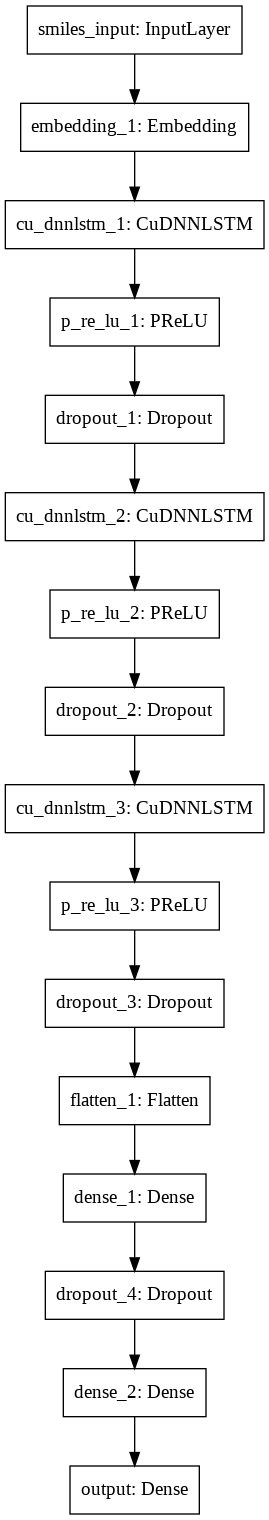

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

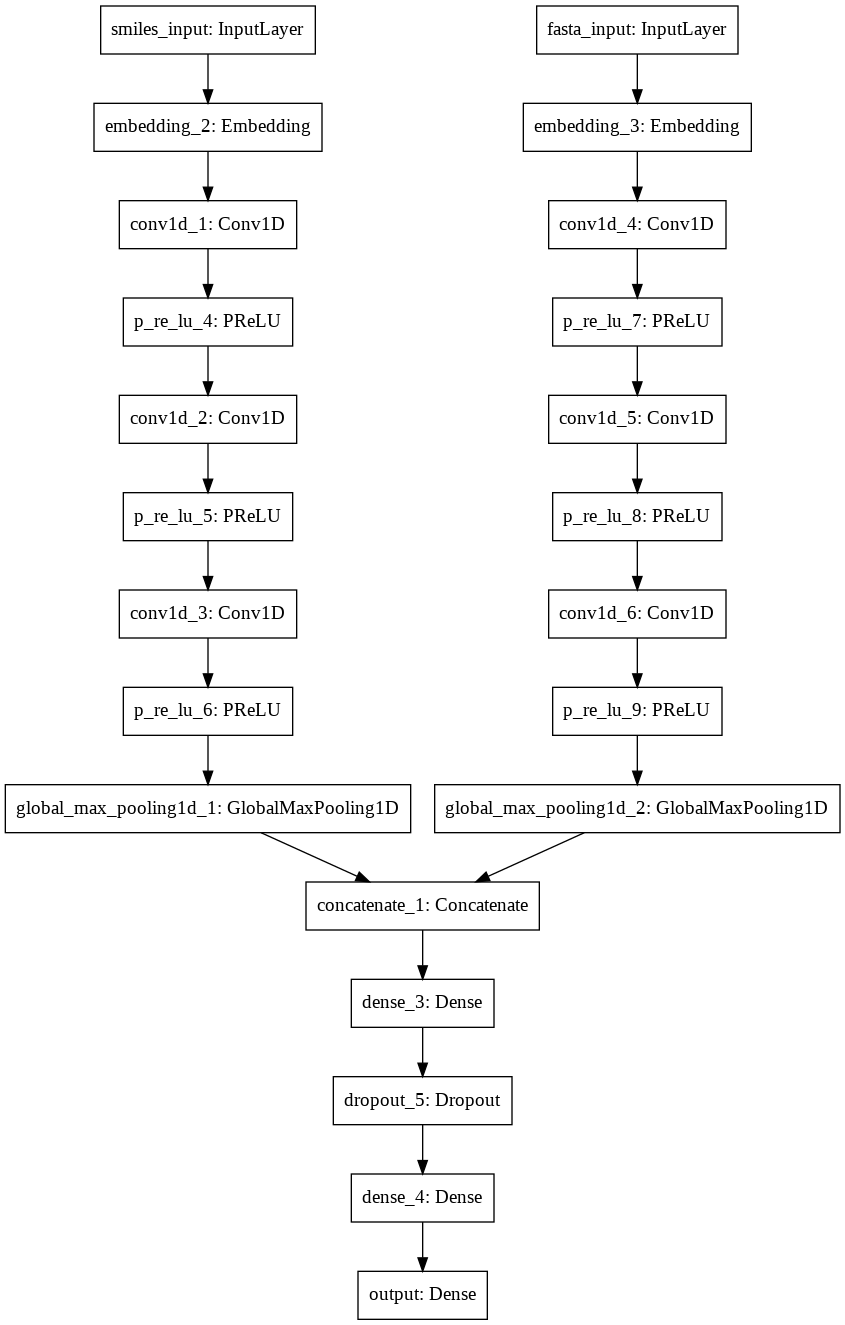

In [ ]:
tf.keras.utils.plot_model(affinity_model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

## Molecule Analysis Methods

In [ ]:
melatonin = "COC1=CC2=C(NC=C2CCNC(C)=O)C=C1"
glycogen = "C(C1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3C(OC(C(C3O)O)O)CO)O)O)OC4C(C(C(C(O4)CO)O)O)O)O)O)O)O"
penicillin = "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C" 

In [ ]:
def test_molecule(molecule):
    if molecule == None or len(molecule) <= 3:
        return False
    mol = Chem.MolFromSmiles(molecule)
    if mol == None:
        return False
    else:
        try:
            Draw.MolToImage(mol) # if molecule is not drawable, the molecule is not valid
            return True
        except:
            return False
      
print(test_molecule(penicillin))
print(test_molecule("abc123"))

True
False


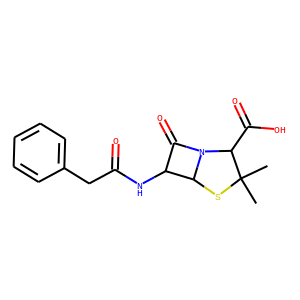

In [ ]:
def draw_compound(molecule):
    m = Chem.MolFromSmiles(molecule)
    weight = Descriptors.MolWt(m)
    return Draw.MolToImage(m)
  
draw_compound(penicillin) 

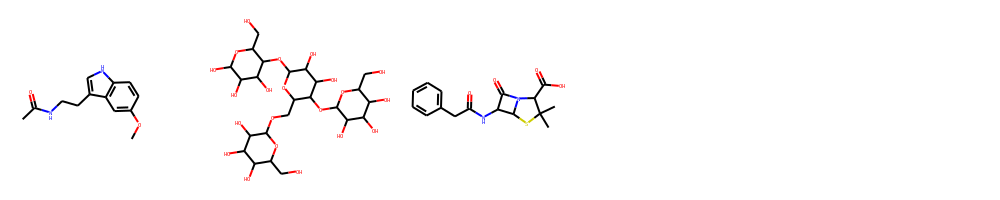

In [ ]:
def draw_list_compounds(molecules):
  list_molecules = []
  for i in molecules:
     list_molecules.append(Chem.MolFromSmiles(i))
  return Draw.MolsToGridImage(list_molecules, molsPerRow=5)

draw_list_compounds([melatonin, glycogen, penicillin])

In [ ]:
def analyze_compound(molecule):
  m = Chem.MolFromSmiles(molecule)
  print("Molecule Weight:", Descriptors.MolWt(m), "g/mol")
  print("Num Atoms:", m.GetNumAtoms())
  print("LogP:", Descriptors.MolLogP(m))
  print("TPSA:", Descriptors.TPSA(m))

analyze_compound(penicillin)

Molecule Weight: 334.39700000000005 g/mol
Num Atoms: 23
LogP: 0.8607999999999993
TPSA: 86.71000000000001


In [ ]:
def get_h_bond_donors(mol): # returns the number of hydrogen bond donors (NH and OH)
    idx = 0
    donors = 0
    while idx < len(mol)-1:
        if mol[idx].lower() == "o" or mol[idx].lower() == "n":
            if mol[idx+1].lower() == "h":
                donors+=1
        idx+=1
    return donors

def get_h_bond_acceptors(mol): # returns the number of hydrogen bond acceptors (N and O)
    acceptors = 0
    for i in mol:
        if i.lower() == "n" or i.lower() == "o":
            acceptors+=1
    return acceptors

# Lipinski's “Rule of Five” - Constraints in order to maintain drug-like character within the compounds
def rule_of_five(molecule):
    m = Chem.MolFromSmiles(molecule)
    if get_h_bond_donors(molecule) <= 5 and get_h_bond_acceptors(molecule) <= 10 and Descriptors.MolWt(m) <= 500 and Descriptors.MolLogP(m) <= 5: # constraints
        return True
    else:
        return False

print(rule_of_five(melatonin))
print(rule_of_five(glycogen)) # not a drug - should be False
print(rule_of_five(penicillin))

True
False
True


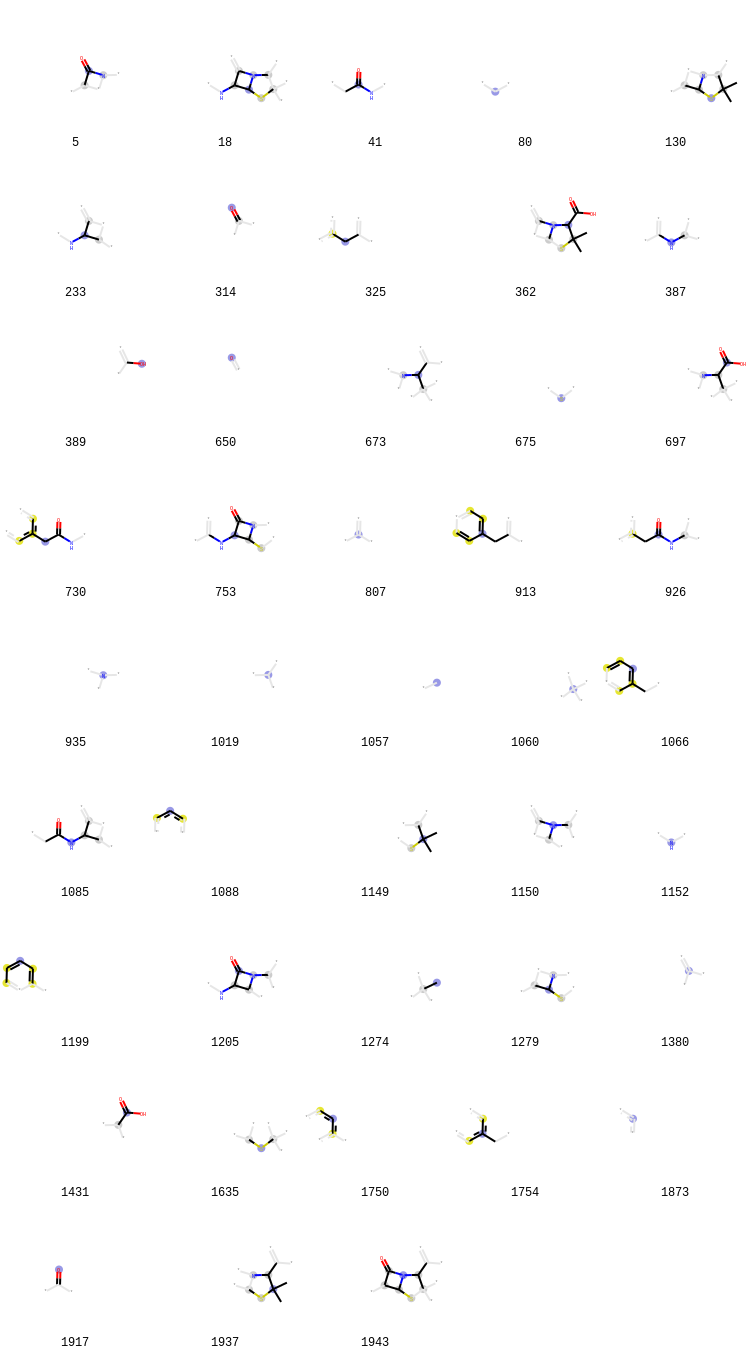

In [ ]:
def fingerprints(molecule): # https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1
  m = Chem.MolFromSmiles(molecule)
  bi = {}
  fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048, bitInfo=bi)
  fp_arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, fp_arr)
  np.nonzero(fp_arr)
  fp_bits = fp.GetOnBits()
  prints = [(m, x, bi) for x in fp_bits]
  return Draw.DrawMorganBits(prints, molsPerRow=5, legends=[str(x) for x in fp_bits])

fingerprints(penicillin)

In [ ]:
def similarity(molecule1, molecule2): # fraction of fingerprints the set of two molecules have in common
    m1 = Chem.MolFromSmiles(molecule1)
    bi1 = {}
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, radius=2, nBits=2048, bitInfo=bi1)
    fp1_bits1 = fp1.GetOnBits()

    m2 = Chem.MolFromSmiles(molecule2)
    bi2 = {}
    fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, radius=2, nBits=2048, bitInfo=bi2)
    fp2_bits2 = fp2.GetOnBits()

    common = set(fp1_bits1) & set(fp2_bits2)
    combined = set(fp1_bits1) | set(fp2_bits2)

    return len(common)/len(combined) # recreation of DataStructs.TanimotoSimilarity

similarity(melatonin, penicillin)

0.1388888888888889

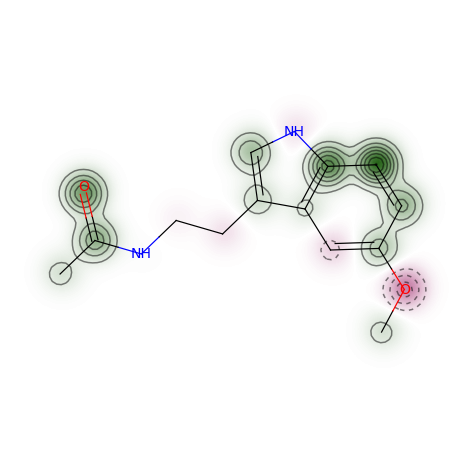

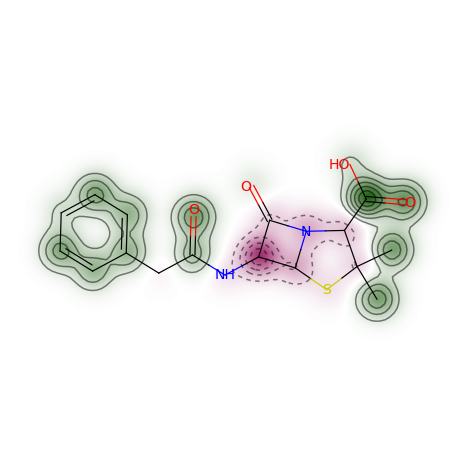

In [ ]:
def similarity_map(molecule1, molecule2):

    m1 = Chem.MolFromSmiles(molecule1)
    m2 = Chem.MolFromSmiles(molecule2)

    fig1, maxweight1 = SimilarityMaps.GetSimilarityMapForFingerprint(m2, m1, SimilarityMaps.GetMorganFingerprint)
    fig2, maxweight2 = SimilarityMaps.GetSimilarityMapForFingerprint(m1, m2, SimilarityMaps.GetMorganFingerprint)

similarity_map(melatonin, penicillin)

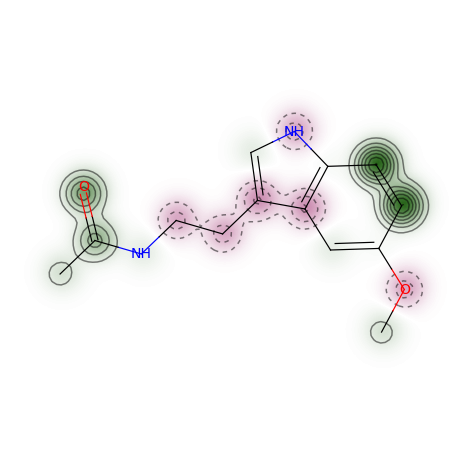

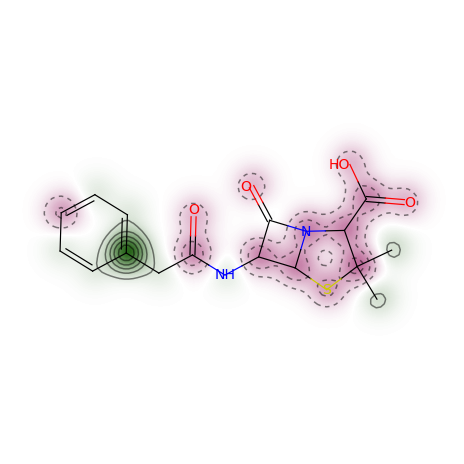

In [ ]:
def similarity_map_tanimoto(molecule1, molecule2, r):

    m1 = Chem.MolFromSmiles(molecule1)
    m2 = Chem.MolFromSmiles(molecule2)

    fig3, maxweight3 = SimilarityMaps.GetSimilarityMapForFingerprint(m2, m1, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=r, fpType='count'), metric=DataStructs.TanimotoSimilarity)
    fig4, maxweight4 = SimilarityMaps.GetSimilarityMapForFingerprint(m1, m2, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=r, fpType='count'), metric=DataStructs.TanimotoSimilarity)

similarity_map_tanimoto(melatonin, penicillin, 1)

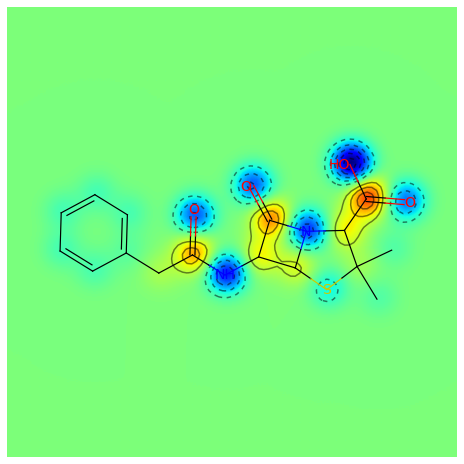

In [ ]:
def gasteiger_partial_charges(molecule):
    mol = Chem.MolFromSmiles(molecule)
    AllChem.ComputeGasteigerCharges(mol)
    contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)

gasteiger_partial_charges(penicillin)

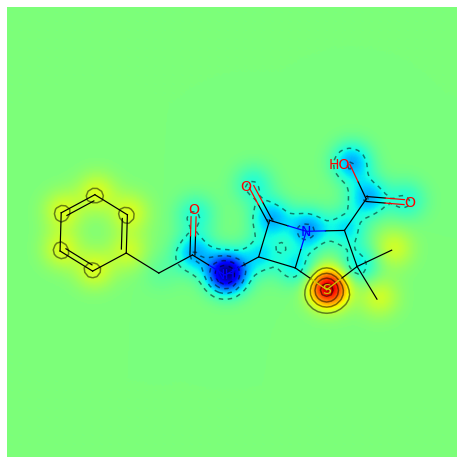

In [ ]:
def crippen_contributions(molecule):
    mol = Chem.MolFromSmiles(molecule)
    contribs = rdMolDescriptors._CalcCrippenContribs(mol)
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in contribs], colorMap='jet', contourLines=10)

crippen_contributions(penicillin)

## Test Affinity Prediction

In [ ]:
def predict_affinity(list_of_smiles, fasta):

    fasta = fasta[:max_fasta] # truncate fasta sequence if it is longer than the maximum sequence length

    # create fasta sequence input
    fasta_in = []
    for amino in fasta:
        fasta_in.append(amino_to_int[amino])
    while(len(fasta_in)!=max_fasta): 
        fasta_in.append(0)

    all_pred = []
    for molecule in list_of_smiles:

        molecule = molecule.replace("b", "B").replace('p',"P") # "b" and "p" are not in the list of elements the affinity model was trained on, but "B" and "P" are, which are the same elements but not in SMILES syntax
        molecule = molecule.replace('/', "").replace('@', "").replace('\\', "").replace('.', "") # affinity data does not include these symbols

        molecule = molecule[:max_smiles] # truncate molecules smiles sequence if it is longer than the maximum sequence length

        # create smiles sequence input
        smiles_in = []
        for element in molecule:
            smiles_in.append(smiles_to_int[element]) 
        while(len(smiles_in)!=max_smiles): 
            smiles_in.append(0)

        pred = affinity_model.predict({'smiles_input': np.array(smiles_in).reshape(1, max_smiles,), 
                                       'fasta_input': np.array(fasta_in).reshape(1, max_fasta,)})[0][0] # make prediction
        all_pred.append(pred)
      
    return all_pred

In [ ]:
predict_affinity([melatonin, penicillin], new_client.target_component.get(new_client.target.get("CHEMBL3927")["target_components"][0]["component_id"])["sequence"]) # protein = SARS 3C-like protease

[6919.3057, 10542.411]

## Generation Methods

In [ ]:
def generate(num_molecules=100):

    new_molecules = []

    while len(new_molecules) != num_molecules: # repeat until num_molecules molecules are generated

        start = np.random.randint(0, len(network_input)-1)
        pattern = network_input[start] # grab a random sequence

        prediction_output = []

        try:
            start_idx = len(list(pattern)) - list(pattern)[::-1].index(element_to_int["$"]) - 1 # get index of last "$" (end token) which is the start of the incomplete molecule built upon
        except:
            start_idx = 0 # in case input does not even have an end token and is just one long molecule
        start_mol = list(pattern)[start_idx+1:]
        for element in start_mol:
            prediction_output.append(int_to_element[element]) # add incomplete molecule to start of output

        # build upon the incomplete molecule with predictions (predicting the next element of the sequence)
        # will stop at 100 predictions or until the end token "$" is predicted
        for element_index in range(100):
            prediction_input = np.reshape(pattern, (1, len(pattern)))
            prediction_input = prediction_input
            prediction = model.predict(prediction_input, verbose=0)
            index = np.argmax(prediction)
            result = int_to_element[index]
            if result == "$":
                break
            prediction_output.append(result)
            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]

        output = "".join(prediction_output)

        for word, initial in single_to_double.items(): 
            output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements   

        if output not in new_molecules and test_molecule(output) and rule_of_five(output): # make sure that the molecules are unique, valid, and drug-like
              print("generated (randomly)", output)
              new_molecules.append(output)

    return new_molecules

In [ ]:
def complete_molecule(inp):

    for word, initial in double_to_single.items(): 
        inp = inp.replace(word, initial) # replace double-letter elements to single-letter for model input

    net_inp = []

    for i in range(0, len(inp)):
        seq_in = inp[i]
        net_inp.append([element_to_int[char] for char in seq_in])

    found = False
    while not found:
        start = np.random.randint(0, len(network_input)-1)
        sample = network_input[start]
        if int_to_element[np.round(sample[-1])] == "$":
            found = True

    sample = sample[len(inp):sequence_length]

    net_in = []
    for i in sample:
      net_in.append(i)
    for j in net_inp:
      net_in.append(j[0])

    net_input = np.reshape(net_in, (1, sequence_length))[0]

    pred_out = []
    for element_index in range(100):
        net_input = np.reshape(net_input, (1, sequence_length))
        prediction = model.predict(net_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_element[index]
        pred_out.append(result)
        net_input = np.append(net_input, index)
        net_input = net_input[1:len(net_input)]

    output = "".join(pred_out)

    for word, initial in single_to_double.items(): 
        output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements

    end_molecule = ""
    for i in range(0, len(output)):
        if output[i] == "$":
          end_molecule = output[:i]
          break

    molecule = inp + end_molecule
    return molecule

def generate_methodical(target_inhibitors_list):

    target_inhibitors = [inhibitor.replace("/", "").replace("@", "").replace("\\", "").replace(".", "") for inhibitor in target_inhibitors_list]

    inhibitors_sequences = []
    for mol in target_inhibitors:
        for cutoff in range(1, len(mol)): 
            inhibitors_sequences.append(mol[:cutoff])

    new_molecules = []
    for seq in inhibitors_sequences:
        new_mol = complete_molecule(seq)
        if new_mol not in new_molecules: # make sure that the molecules are unique
          if test_molecule(new_mol) and rule_of_five(new_mol): # make sure that the molecules are valid and drug-like
              new_molecules.append(new_molecules.append(new_mol))
              print("generated (methodically)", new_mol)

    return new_molecules

In [ ]:
def complete(inp): # helper method for augment - returns a prediction in place of the removed element

    for word, initial in double_to_single.items(): 
        inp = inp.replace(word, initial) # replace double-letter elements to single-letter for model input

    net_inp = []

    for i in range(0, len(inp)):
        seq_in = inp[i]
        net_inp.append([element_to_int[char] for char in seq_in])

    found = False
    while not found: # find sequence with the end token "$" at the end
        start = np.random.randint(0, len(network_input)-1)
        pattern = network_input[start]
        if int_to_element[np.round(pattern[-1])] == "$":
            found = True

    net_in = []
    for i in pattern[len(inp):sequence_length]:
      net_in.append(i)
    for j in net_inp:
      net_in.append(j[0])

    net_in = np.reshape(net_in, (1, sequence_length))

    prediction = model.predict(net_in, verbose=0) # make prediction
    index = np.argmax(prediction)
    result = int_to_element[index]

    return result

def augment(compound, num_changes): # could enhance the pharmacokinetics and bioactivity of the compound

    for word, initial in double_to_single.items(): 
        compound = compound.replace(word, initial) # replace double-letter elements to single-letter for model input

    changes = np.random.randint(1, num_changes+1)
    for i in range(0, changes): # randomly removes certain amount of random elements in SMILES string compound and replaces them with prediction
        ind = np.random.randint(0, len(compound))
        changed = compound[ind]
        new_compound = compound[:ind]
        
        result = complete(new_compound)
        if result == "$":
            return compound[:ind] # if an end token is predicted, return the part of the compound up to the changed index
        else:
            compound = compound[:ind] + result + compound[ind+1:] # add the prediction in place of the removed element

    return compound # return the augmented compound after all the changes have been made

def augment_repeat(inp, sim, changes, max_try):

  if len(inp) > sequence_length:
      inp = inp[:sequence_length]

  tries = 0
  while tries < max_try: # keep trying to make augmented molecules until the model has exceeded the max number of tries (max_try)

      augmented = augment(inp, changes)
      tries += 1 
      for word, initial in single_to_double.items(): 
        augmented = augmented.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements
      try:
          if test_molecule(augmented) and augmented != inp and rule_of_five(augmented): # make sure that the molecules are valid and drug-like
              s = similarity(inp, augmented) # calculate similarity between the original molecule and the augmented molecule
              if sim < s < 1: # make sure the molecule follows the similarity threshold
                  print("augmented", inp, "-->", augmented, "with similarity", s)
                  return augmented
      except:
          continue

  print("could not augment", inp, "within", tries, "tries")

def aug_list(inp_list, similarity=0.2, max_changes=20, max_tries=100):

    molecules = [augment_repeat(compound.replace('/', "").replace('@', "").replace('\\', "").replace('.', ""), similarity, max_changes, max_tries) for compound in inp_list]
    molecules = list(set(molecules)) # remove duplicates
    molecules = [i for i in molecules if i] 
    return molecules

## Create Drugs

In [ ]:
def get_affinity_inhibitors():

    print("what would you like to search for? \n")

    search = str(input())

    target = new_client.target # gets all target information from ChEMBL database
    target_query = target.search(search) # search for disease, virus, etc.
    targets = pd.DataFrame.from_dict(target_query) # turn data into pandas dataframe
    if len(targets) == 0:
        print("\nno search results")
        return
    
    name_to_id = dict(zip(targets.pref_name, targets.target_chembl_id)) # dictionary linking target names to their respective ChEMBL ID
    names = []
    seqs = []
    for name in name_to_id:
        try:
            seqs.append(new_client.target_component.get(new_client.target.get(name_to_id[name])["target_components"][0]["component_id"])["sequence"]) # make sure protein sequence is obtainable
            names.append(name)
        except:
            continue 
    print("\nchoose a target\n")
    print(names, "\n") # target protein names

    target_protein = str(input())
    if target_protein not in names:
        print("\ntarget not in list")
        return

    selected_target = name_to_id[target_protein] # get ChEMBL ID of the selected target
    target_fasta = new_client.target_component.get(new_client.target.get(selected_target)["target_components"][0]["component_id"])["sequence"] # get the protein sequence fasta of the target protein

    activity = new_client.activity # get all protein-ligand data

    print("\nwould you like to make sure all the compounds are inhibitory? this may reduce the number of compounds outputted as some compounds are inhibitory but may have a different standard type? (yes/no) \n")
    answer = str(input())
    if answer == "yes":
        res = activity.filter(target_chembl_id=selected_target).filter(standard_type="Inhibition") # filter data strictly to inhibitors of the selected target protein
    elif answer == "no":
        res = activity.filter(target_chembl_id=selected_target) # filter data to all ligands capable of interacting with the selected target protein
    else:
        print("\nit was a yes or no question!")
        return

    df = pd.DataFrame.from_dict(res) # turn data into pandas dataframe

    inhibitors = df.canonical_smiles
    inhibitors = list(set(inhibitors)) # remove duplicates
    affinities = predict_affinity(inhibitors, target_fasta) # predict the affinities of the molecules
    molecules_and_affinities = dict(zip(inhibitors, affinities)) # make a dictionary of the molecules and their respective affinities
    sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=False) # get the best molecules
    sorted_affinities = sorted(affinities) # get the best affinities

    all_mols = pd.DataFrame({"molecule":sorted_molecules, 
                             "affinity":sorted_affinities})

    return all_mols

In [ ]:
def PharmaceuticAI():

    print("welcome to PharmaceuticAI")
    print("what would you like to search for? \n")

    search = str(input())

    target = new_client.target # gets all target information from ChEMBL database
    target_query = target.search(search) # search for disease, virus, etc.
    targets = pd.DataFrame.from_dict(target_query) # turn data into pandas dataframe
    if len(targets) == 0:
        print("\nno search results")
        return
    
    name_to_id = dict(zip(targets.pref_name, targets.target_chembl_id)) # dictionary linking target names to their respective ChEMBL ID
    names = []
    seqs = []
    for name in name_to_id:
        try:
            seqs.append(new_client.target_component.get(new_client.target.get(name_to_id[name])["target_components"][0]["component_id"])["sequence"]) # make sure protein sequence is obtainable
            names.append(name)
        except:
            continue 
    print("\nchoose a target\n")
    print(names, "\n") # target protein names

    target_protein = str(input())
    if target_protein not in names:
        print("\ntarget not in list")
        return

    selected_target = name_to_id[target_protein] # get ChEMBL ID of the selected target
    target_fasta = new_client.target_component.get(new_client.target.get(selected_target)["target_components"][0]["component_id"])["sequence"] # get the protein sequence fasta of the target protein

    print("\nprotein sequence for target", target_protein+":", target_fasta)
    print("length of protein sequence:", len(target_fasta))

    activity = new_client.activity # get all protein-ligand data

    print("\nwould you like to make sure all the compounds are inhibitory? this may reduce the number of compounds outputted as some compounds are inhibitory but may have a different standard type? (yes/no) \n")
    answer = str(input())
    if answer == "yes":
        res = activity.filter(target_chembl_id=selected_target).filter(standard_type="Inhibition") # filter data strictly to inhibitors of the selected target protein
    elif answer == "no":
        res = activity.filter(target_chembl_id=selected_target) # filter data to all ligands capable of interacting with the selected target protein
    else:
        print("\nit was a yes or no question!")
        return

    df = pd.DataFrame.from_dict(res) # turn data into pandas dataframe

    mols = []

    if len(df) == 0: # if no existing inhibitors are found, generate many random molecules, pick the best ones, and iterate off of them

        print("\nno existing inhibitors found")

        print("\nhow many iterations would you like to make? (integer > 0) \n")
        iterations = str(input())
        try:
            iterations = int(iterations)
            if iterations <= 0:
                print("\nhas to be an integer > 0")
                return
        except:
            print("\nhas to be > 0")
            return
        
        print("\ngenerating random molecules...")
        mols += generate(25000) # generate random molecules
        mols = list(set(mols)) # remove duplicates

        affinities = predict_affinity(mols, target_fasta) # predict the affinities of the random molecules
        molecules_and_affinities = dict(zip(mols, affinities)) # make a dictionary of the molecules and their respective affinities
        sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=False) # get the best molecules
        sorted_affinities = sorted(affinities) # get the best affinities
        for mol, aff in zip(sorted_molecules, sorted_affinities): # print the best molecules and their affinities
            print("molecule:", mol, "IC50:", aff)

        molecules = sorted_molecules[:100] # take the best n molecules and use them to iterate off of
        for iter in range(iterations):

            print("\nstarting iteration", iter+1)

            mols += aug_list(molecules, similarity=0, max_changes=20, max_tries=100) # iterate off of the best molecules
            mols += generate_methodical(molecules) # iterate off of the best molecules
            mols += generate(2500) # generate many random molecules as well in case they somehow perform decently
            mols = list(set(mols)) # remove duplicates

            affinities = predict_affinity(mols, target_fasta) # predict the affinities of the new molecules
            molecules_and_affinities = dict(zip(mols, affinities)) # make a dictionary of the molecules and their respective affinities
            sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=False) # get the best molecules
            sorted_affinities = sorted(affinities) # get the best affinities
            for mol, aff in zip(sorted_molecules[::-1], sorted_affinities[::-1]): # print the best molecules and their affinities
                print("molecule:", mol, "IC50:", aff)

            molecules = sorted_molecules[:50] # take the best n molecules and use them in the next iteration

    else:

        target_inhibit_list = df.canonical_smiles # get all inhibitors of the target protein in SMILES format
        target_inhibit_list = list(set(target_inhibit_list)) # remove duplicates

        print("\n"+str(len(target_inhibit_list)), "existing inhibitors found with the following descriptions:")
        print(df.assay_description.unique())
        
        print("\ninhibitors:", list(target_inhibit_list))

        print("\nhow many iterations would you like to make? (integer > 0) \n")
        iterations = str(input())
        try:
            iterations = int(iterations)
            if iterations <= 0:
                print("\nhas to be an integer > 0")
                return
        except:
            print("\nhas to be > 0")
            return

        molecules = target_inhibit_list
        for iter in range(iterations):

            print("\nstarting iteration", iter+1)

            mols += aug_list(molecules, similarity=0, max_changes=20, max_tries=100) # iterate off of the existing inhibitors, and the best molecules in later iterations
            mols += generate_methodical(molecules) # iterate off of the existing inhibitors, and the best molecules in later iterations
            mols += generate(2500) # generate many random molecules as well in case they somehow perform decently 
            mols = list(set(mols)) # remove duplicates

            affinities = predict_affinity(mols, target_fasta) # predict the affinities of the new molecules
            molecules_and_affinities = dict(zip(mols, affinities)) # make a dictionary of the molecules and their respective affinities
            sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=False) # get the best molecules
            sorted_affinities = sorted(affinities) # get the best affinities
            for mol, aff in zip(sorted_molecules[::-1], sorted_affinities[::-1]): # print the best molecules and their affinities
                print("molecule:", mol, "affinity:", aff)

            molecules = sorted_molecules[:50] # take the best n molecules and use them in the next iteration

    mols = list(set(mols)) # in case of duplicates
    mols = [m for m in mols if m not in target_inhibit_list] # in case existing inhibitors are in the list of generated molecules
    affinities = predict_affinity(mols, target_fasta) # predict the affinities of the molecules
    molecules_and_affinities = dict(zip(mols, affinities)) # make a dictionary of the molecules and their respective affinities
    sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=False) # get the best molecules
    sorted_affinities = sorted(affinities) # get the best affinities

    all_mols = pd.DataFrame({"molecule":sorted_molecules, "IC50":sorted_affinities}).reset_index(drop=True)

    return all_mols

In [ ]:
generated = PharmaceuticAI()

In [ ]:
generated.head(10)

In [ ]:
generated.tail()

In [ ]:
generated.to_csv("generated_compounds.csv")
files.download("generated_compounds.csv")

In [ ]:
inhibitors = get_affinity_inhibitors() 

what would you like to search for? 

coronavirus

choose a target

['SARS coronavirus 3C-like proteinase', 'Replicase polyprotein 1ab'] 

SARS coronavirus 3C-like proteinase

would you like to make sure all the compounds are inhibitory? this may reduce the number of compounds outputted as some compounds are inhibitory but may have a different standard type? (yes/no) 

no


In [ ]:
inhibitors.head(10)

,molecule,affinity
0,COc1ccc([N+](=O)[O-])c(S(=O)(=O)c2ccccc2)n1,3465.801270
1,CC(C)[C@H](NC(=O)[C@@H]1O[C@@H]1C)C(=O)OCc1ccccc1,4313.145508
2,COC(=O)c1ccc2c(c1)C(=O)C(=O)N2C,4551.343750
3,CC(C)[C@H](NC(=O)C1C(c2ccccc2)N1Cc1ccccc1)C(=O...,4583.564941
4,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,5263.032227
5,O=C1Nc2ccc(I)cc2C1=O,5299.175293
6,COC(=O)c1ccc2c(c1)C(=O)C(=O)N2Cc1ccccc1,5367.190918
7,O=S(=O)(Cc1[nH]c(-c2ccc(Cl)s2)c[s+]1)c1cccs1.[...,5381.294434
8,CC(OC(C)(C)C)[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@...,5668.432617
9,C[C@H]1O[C@H]1C(=O)O,5888.272949


In [ ]:
inhibitors.tail()

,molecule,affinity
196,COc1cccc(-c2nc(SCC(=O)Nc3ccc(S(N)(=O)=O)cc3)nc...,17435.951172
197,O=C(Oc1cncc(Cl)c1)c1cc2ccccc2[nH]1,17453.736328
198,O=C(Oc1ccncc1)c1cccs1,17734.294922
199,C[C@H]1[C@@H](C(=O)N[C@@H](Cc2ccccc2)C(=O)OCc2...,18186.263672
200,O=C(Oc1ccccn1)c1cccs1,22280.193359


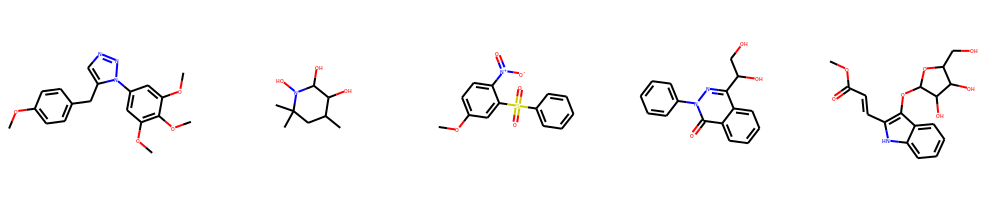

In [ ]:
draw_list_compounds(generated.molecule[:5]) # best 5 generated compounds

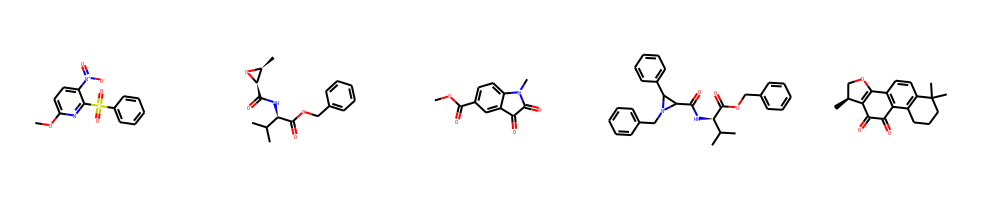

In [ ]:
draw_list_compounds(inhibitors.molecule[:5]) # best 5 inhibitors

COc1ccc(Cc2cnnn2-c2cc(OC)c(OC)c(OC)c2)cc1


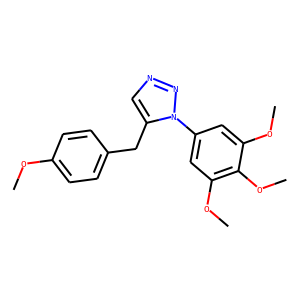

In [ ]:
best_molecule = generated.molecule[0]
print(best_molecule)
print(analyze_compound(best_molecule))
draw_compound(best_molecule)

In [ ]:
similarity(best_molecule, inhibitors.molecule[0])

0.11940298507462686

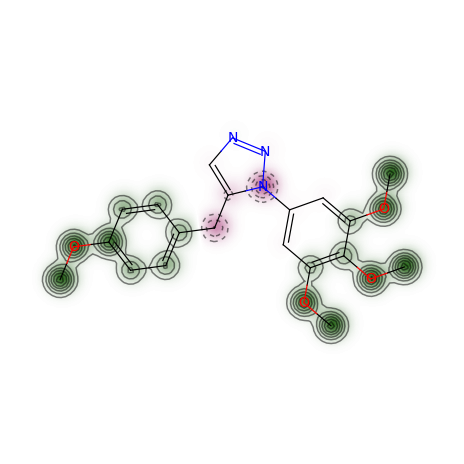

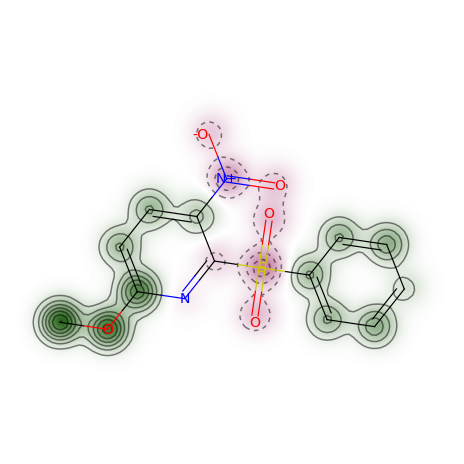

In [ ]:
similarity_map(generated.molecule[0], inhibitors.molecule[0])

In [ ]:
highest_similarity = 0
for inhibitor in inhibitors.molecule:
    if similarity(best_molecule, inhibitor) > highest_similarity:
        highest_similarity = similarity(best_molecule, inhibitor)
highest_similarity # highest similarity between the best generated compound and any existing inhibitor

0.1875

Submit SARS 3C-like protease inhibitors to https://postera.ai/covid --> https://postera.ai/covid/activity_data